In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import re
import pandasql
url = 'https://xn--80aesfpebagmfblc0a.xn--p1ai/covid_data.json?do=region_stats&code='
geo_codes = requests.get('https://ru.wikipedia.org/wiki/ISO_3166-2:RU').text
co = requests.get('https://xn--80aesfpebagmfblc0a.xn--p1ai/information/').text
c = co[16655:376929]
codes = BeautifulSoup(geo_codes, 'lxml')
sick = []
healed = []
Data = []
GeoCode = []
Regg = []
for ele, xx in enumerate(re.split('"code"|"is_city"|"title"', c)[:255]):
    if ele % 3 == 1:
        ri = xx
        new_ri = ri.strip(':').strip(',')
    if ele % 3 == 2:
        code = xx
        new_codes = code.strip(':').strip('""').strip(',').strip('""')
        Regg.append(json.loads(new_ri))
        GeoCode.append(new_codes)


        
for el in range(len(GeoCode)):
    urls = url + GeoCode[el]
    url_n = requests.get(urls).json()
    sick = [float(url_n[:8][i]['sick']) for i in range(len(url_n[:8]))]# данные по выявленным случаям
    healed = [float(url_n[:8][i]['healed']) for i in range(len(url_n[:8]))]# данные по выздоровевшим
    diff = sum([x - y for x, y in zip(sick, healed)])
    Data.append(diff)

Df1 = pd.DataFrame()
Df1['Sick_for_week'] = Data
Df1['Region'] = Regg
Df1 = Df1.sort_values(by=['Region'])
Df1.index = [index for index in range(1,86)]
Df1





ValueError: Length mismatch: Expected axis has 53 elements, new values have 85 elements

In [114]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import json
import re
import pandasql
from nltk.metrics import edit_distance
url_people = requests.get('http://www.statdata.ru/largest_regions_russia').text
soup2 = BeautifulSoup(url_people, 'lxml')
data2 = [el.text for el in soup2.select('td[style]')[49:702]]


reg = [district.replace('г.', '').strip() for district in data2[:653:7]]
Pop = [float(number.replace(' ', '')) for number in data2[1:653:7]]

#print(Pop)
Df2 = pd.DataFrame()
Df2['Population'] = Pop
Df2['Reg'] = reg

querry = """ 
    SELECT *
    FROM Df2 
    Where Reg NOT IN ('Архангельская область', ' Дальневосточный ФО', 'Приволжский ФО', 'Северо-Западный ФО',
    'Тюменская область', 'Уральский ФО', 'Сибирский ФО', 'Южный ФО') AND Population NOT IN 
    (1136535.0, 13981992.0, '16466084.0', '9930933.0', '29287683.0', '12360752.0', '3756536.0', 
    '17118387.0', '8169203.0')"""
Df2 = pandasql.sqldf(querry, locals())
Df2 = Df2.sort_values(by=['Reg'])
Df2.index = [num for num in range(1,86)]
Df2
New_Data = Df2.join(Df1, how='left')

New_Data

,Population,Reg,Sick_for_week,Region
1,2317153.0,Алтайский край,21983.0,Алтайский край
2,790044.0,Амурская область,20354.0,Амурская область
3,1092424.0,Архангельская обл. без НАО,87456.0,Архангельская область
4,1005782.0,Астраханская область,26988.0,Астраханская область
5,1549151.0,Белгородская область,14416.0,Белгородская область
...,...,...,...,...
81,1478726.0,Чеченская Республика,15335.0,Челябинская область
82,1217818.0,Чувашская Республика,8355.0,Чеченская Республика
83,50288.0,Чукотский автономный округ,412.0,Чукотский автономный округ
84,544444.0,Ямало-Ненецкий АО,60402.0,Ямало-Ненецкий автономный округ


In [177]:
url3 = requests.get('http://www.statdata.ru/ploshchad/rossii').text
soup3 = BeautifulSoup(url3, 'lxml')

spi = [el.text.strip() for el in soup3.select('td[style]')[37:] if len(el.text) >=3 and ',' not in el.text]

squares = [float(fig.replace(' ','')) for fig in spi[1:261:3] if fig != '589 913'and fig != '1 464 173']

regs = [reg for reg in spi[:261:3] if reg != 'Тюменская обл. с АО' and reg != 'Архангельская обл. с НАО']

Df3 = pd.DataFrame()
Df3['Squares'] = squares
Df3['Regs'] = regs
Df3 = Df3.sort_values(by=['Regs'])
Df3.index = [d for d in range(1,86)]
Df3

Common_Data = Df3.join(New_Data, how='left')
Common_Data

,Squares,Regs,Population,Reg,Sick_for_week,Region
1,167996.0,Алтайский край,2317153.0,Алтайский край,21983.0,Алтайский край
2,361908.0,Амурская область,790044.0,Амурская область,20354.0,Амурская область
3,413103.0,Архангельская обл. без НАО,1092424.0,Архангельская обл. без НАО,87456.0,Архангельская область
4,49024.0,Астраханская область,1005782.0,Астраханская область,26988.0,Астраханская область
5,27134.0,Белгородская область,1549151.0,Белгородская область,14416.0,Белгородская область
...,...,...,...,...,...,...
81,15647.0,Чеченская Республика,1478726.0,Чеченская Республика,15335.0,Челябинская область
82,18343.0,Чувашская Республика,1217818.0,Чувашская Республика,8355.0,Чеченская Республика
83,721481.0,Чукотский автономный округ,50288.0,Чукотский автономный округ,412.0,Чукотский автономный округ
84,769250.0,Ямало-Ненецкий ао,544444.0,Ямало-Ненецкий АО,60402.0,Ямало-Ненецкий автономный округ


In [181]:
Common_Data['RO'] = Common_Data['Sick_for_week'] / Common_Data['Squares']
Common_Data


,Squares,Regs,Population,Reg,Sick_for_week,Region,RO
1,167996.0,Алтайский край,2317153.0,Алтайский край,21983.0,Алтайский край,0.130854
2,361908.0,Амурская область,790044.0,Амурская область,20354.0,Амурская область,0.056241
3,413103.0,Архангельская обл. без НАО,1092424.0,Архангельская обл. без НАО,87456.0,Архангельская область,0.211705
4,49024.0,Астраханская область,1005782.0,Астраханская область,26988.0,Астраханская область,0.550506
5,27134.0,Белгородская область,1549151.0,Белгородская область,14416.0,Белгородская область,0.531289
...,...,...,...,...,...,...,...
81,15647.0,Чеченская Республика,1478726.0,Чеченская Республика,15335.0,Челябинская область,0.980060
82,18343.0,Чувашская Республика,1217818.0,Чувашская Республика,8355.0,Чеченская Республика,0.455487
83,721481.0,Чукотский автономный округ,50288.0,Чукотский автономный округ,412.0,Чукотский автономный округ,0.000571
84,769250.0,Ямало-Ненецкий ао,544444.0,Ямало-Ненецкий АО,60402.0,Ямало-Ненецкий автономный округ,0.078521


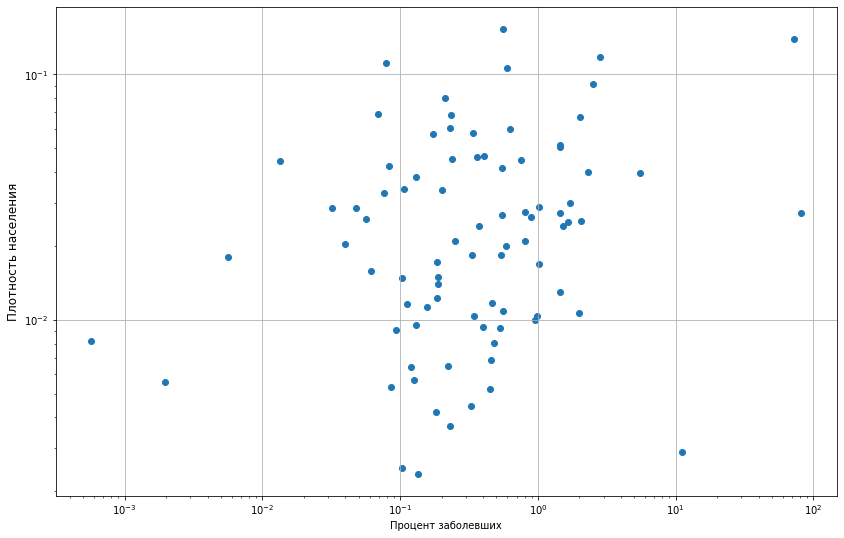

In [237]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#plt.plot(Common_Data.Region, Common_Data.Sick_for_week)
fig, ax = plt.subplots(1,1, figsize=(14,9))
ax.scatter(Common_Data.RO, Common_Data.Sick_for_week / Common_Data.Population)
ax.grid()
ax.set_ylabel('Плотность населения', fontsize=12)
ax.set_xlabel('Процент заболевших')
ax.set_yscale('log')
ax.set_xscale('log')

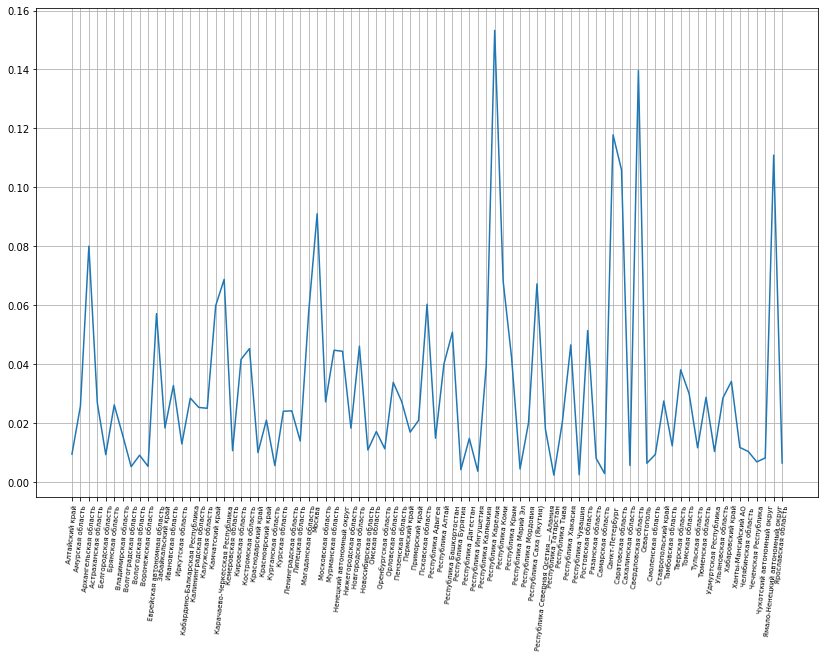

In [235]:
fig, ax = plt.subplots(1,1, figsize=(14,9))
ax.plot( Common_Data.Region, Common_Data.Sick_for_week / Common_Data.Population)
plt.xticks(fontsize=7, rotation=84)
ax.grid()
